In [2]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [7]:
#Read the csv file
df = pd.read_csv("price_temp_total - Copy.csv")
print(df.head())

   Unnamed: 0 SETTLEMENTDATE  TOTALDEMAND     RRP  Tempreture  log_price
0           1  1/1/2018 1:00      1242.28  103.31        17.3   3.322903
1           3  1/1/2018 2:00      1112.46   85.24        17.0   3.319156
2           5  1/1/2018 3:00      1083.94   80.89        16.6   3.318249
3           7  1/1/2018 4:00      1032.95   80.10        16.3   3.318084
4           9  1/1/2018 5:00      1034.12   80.07        16.1   3.318078


In [11]:
train_dates = pd.to_datetime(df['SETTLEMENTDATE'])

#Variables for training
cols = list(df)[2:6]
#Date is not used in training. 
print(cols) 
#New dataframe with only training data - 3 columns
df_for_training = df[cols].astype(float)
print(df_for_training.head)
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training.shape)
# print(df_for_training_scaled.shape)

['TOTALDEMAND', 'RRP', 'Tempreture', 'log_price']
<bound method NDFrame.head of        TOTALDEMAND     RRP  Tempreture  log_price
0          1242.28  103.31        17.3   3.322903
1          1112.46   85.24        17.0   3.319156
2          1083.94   80.89        16.6   3.318249
3          1032.95   80.10        16.3   3.318084
4          1034.12   80.07        16.1   3.318078
...            ...     ...         ...        ...
40699      2253.68  263.00         9.7   3.354685
40700      2123.04  179.98         9.3   3.338453
40701      1919.08  176.00         9.0   3.337659
40702      1696.57  162.43         8.8   3.334942
40703      1686.08  164.28         8.6   3.335313

[40704 rows x 4 columns]>
(40704, 4)


In [12]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 3:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 3]) # 1 mean column of RRP
    
#In my case, trainX1 has a shape (40690 , 14, 3). 
#40690 because we are looking back 14 days (40704  - 14 = 40690). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#To predict more days in future, we need all the 3 variables which we do not have. 
#We need to predict all variables if we want to do that. 

trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (40690, 14, 1).
trainY shape == (40690, 1).


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2616/2616 [==============================] - 47s 17ms/step - loss: 1.0169 - val_loss: 2.5079
Epoch 2/5
2616/2616 [==============================] - 42s 16ms/step - loss: 0.

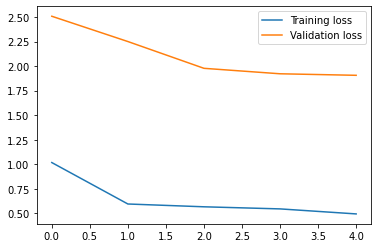

In [13]:
# define the model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=14, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [25]:
# model.save('model_2')

In [8]:
# model = load_model('model')

In [6]:
#Predicting seen data
#Remember that we can only predict one day in future as our model needs 5 variables

n_past = 16
n_days_for_prediction=100 #let us predict past 15 days

# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[:100]) #shape = (n, n_past_from_training, n_of_columns) where n is the n_days_for_prediction
print(prediction.shape)


4/4 [==============================] - 0s 7ms/step
(100, 1)


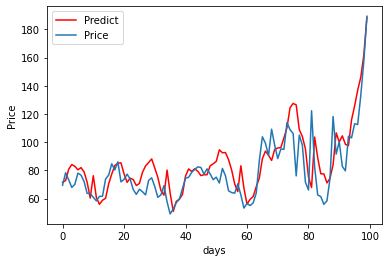

In [7]:
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 3 times to make shape similar to original data to inverse transform.
#Perform inverse transformation to rescale back to original range

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred = scaler.inverse_transform(prediction_copies)[:,1] # RRP

prediction_copies = np.repeat(trainY[:100], df_for_training.shape[1], axis=-1)
y_inverse = scaler.inverse_transform(prediction_copies)[:,1]# RRP

plt.plot(y_pred,c='red',label="Predict")
plt.plot(y_inverse,label="Price")
plt.legend(loc="upper left")
plt.xlabel("days")
plt.ylabel("Price")
plt.show()


In [8]:
Error = y_pred - y_inverse
MBE = np.mean(Error)
print(f'MBE is  {MBE}')
NMBE = np.mean(y_inverse)/MBE
print(f'NMBE is  {NMBE}')
Err_2 = np.power(Error, 2)
print(f'R-square {sum(Err_2)}')
NRMSE = np.mean(np.sqrt(Err_2))
print(f'NRMSE is  {NRMSE}')

MBE is  5.530232249450685
NMBE is  14.355870860195049
R-square 19913.187705422337
NRMSE is  10.36757506866455


In [9]:
#Predicting Unseen data
#Remember that we can only predict one day in future as our model needs 5 variables

n_past = 16
n_days_for_prediction=100 #let us predict past 15 days

# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# print(predict_period_dates)

# testX, testY = np.array(trainX[-100:]), np.array(trainY[-100:])
#Make prediction
prediction = model.predict(trainX[-100:-50]) #shape = (n, n_past_from_training, n_of_columns) where n is the n_days_for_prediction

print(prediction.shape)


2/2 [==============================] - 0s 7ms/step
(50, 1)


In [10]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
prediction_copies = scaler.inverse_transform(prediction_copies)[:,1]
# unseen_data = df_for_training.iloc[-100:-50,0].values
# unseen_data = df_for_training.iloc[-200:-100,0].values
# plt.plot(y_pred_future,c='red')
# plt.plot(unseen_data)
# plt.show()
prediction_copies.shape
# prediction_copies

(50,)

In [19]:
predict = pd.DataFrame(data=prediction_copies, columns=['pred'])
original = df[['SETTLEMENTDATE', 'RRP']]
original['SETTLEMENTDATE']=pd.to_datetime(original['SETTLEMENTDATE'])


predict["date"] = original.iloc[-50:,]['SETTLEMENTDATE'].values
original_2 = original.iloc[-200:-50,]
# original_2

sns.lineplot(original_2,x=range(0,150), y=original_2.RRP.values)


# sns.lineplot(predict,x=range(150,200), y='pred')


C:\Users\Admin\AppData\Local\Temp\ipykernel_14208\1112465332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['SETTLEMENTDATE']=pd.to_datetime(original['SETTLEMENTDATE'])
D:\Projects\Conda\envs\tensorflow_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)